# Using a decision tree to predict financial distress
### Machine Learning for Public Policy - HW #2
### Cecile Murray


Every year, millions of people experience financial distress. In this assignment, I use a Kaggle dataset to predict who will experience a serious delinquency.

### Load and explore data

Before creating the decision tree classifier, I performed some basic exploratory analysis on the data to improve my understanding of how different variables relate to whether a person was more than 90 days delinquent in the past two years. From this analysis, I identified a few notable facts:

* About 16 percent of people in the dataset experienced a serious delinquency. 
* People who experienced a serious delinquency were about seven years younger, on average; a much smaller share of people over age 60 experienced such a delinquency.
* Unsurprisingly, the share of people with a serious delinquency was lower among those with higher monthly incomes, but the age trend persisted even after conditioning on income. Even low-income people over age 60 had relatively low rates of serious delinquency.
* People with higher credit utilization also had higher delinquency rates. 

In [1]:
# import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pipeline as pipe
%matplotlib inline

# Set global variables
RANDOM_SEED = 30254

In [2]:
# read in data and look at first few rows
credit_raw = pipe.read_data("credit-data.csv", file_type = 'csv')

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0
1,98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0
2,99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0
3,99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0
4,99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0


In [3]:
# get basic descriptive stats on all columns
pipe.get_desc_stats(credit_raw)

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,41016.000000,41016.000000,41016.00000,41016.000000,41016.000000,41016.000000,41016.000000,3.304200e+04,41016.000000,41016.000000,41016.000000,41016.000000,39979.000000
mean,115800.154598,0.161400,6.37587,51.683489,60623.824166,0.589233,331.458137,6.578996e+03,8.403477,0.419592,1.008801,0.371587,0.773231
std,28112.723511,0.367904,221.61895,14.746880,11.984357,5.205628,1296.109695,1.344683e+04,5.207324,5.190382,1.153826,5.169641,1.121269
min,22.000000,0.000000,0.00000,21.000000,60601.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106539.750000,0.000000,0.03431,41.000000,60618.000000,0.000000,0.176375,3.333000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,119901.500000,0.000000,0.18973,51.000000,60625.000000,0.000000,0.369736,5.250000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,134698.250000,0.000000,0.66716,62.000000,60629.000000,0.000000,0.866471,8.055750e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,149999.000000,1.000000,22000.00000,109.000000,60644.000000,98.000000,106885.000000,1.794060e+06,56.000000,98.000000,32.000000,98.000000,13.000000


In [21]:
credit = pipe.replace_missing(credit_raw, 'MonthlyIncome', method = 'median')

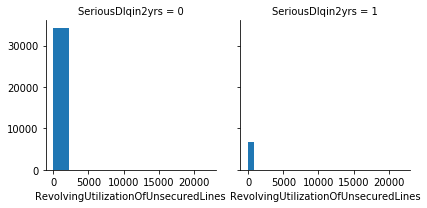

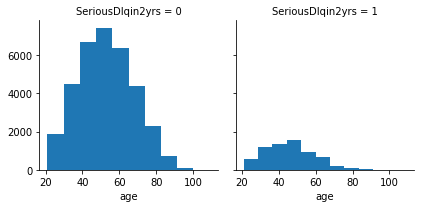

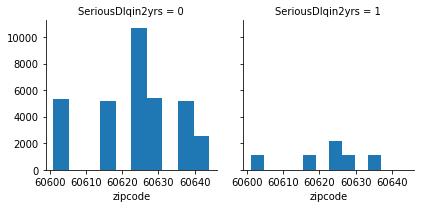

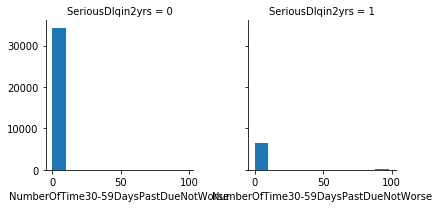

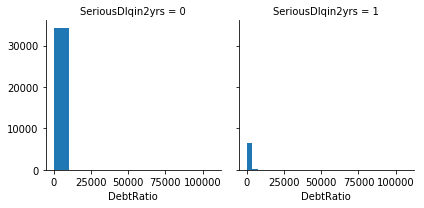

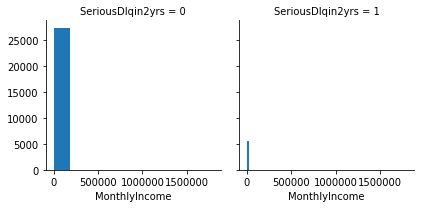

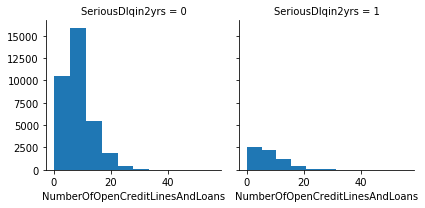

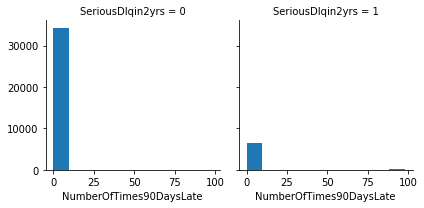

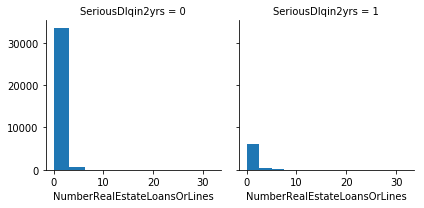

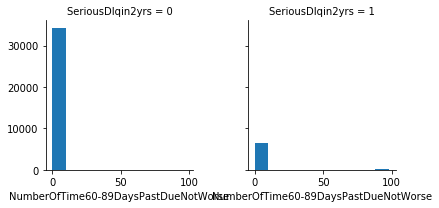

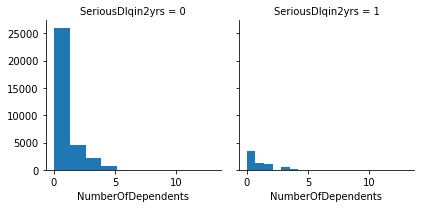

In [7]:
# make histograms of all potential features vs. target variable
plotvars = list(credit.columns[2:])
pipe.plot_cond_dist(credit, 'SeriousDlqin2yrs', *plotvars)

In [27]:
# look for outliers in key variables
pipe.find_outliers(credit, 0, 100, 'age')
pipe.find_outliers(credit, 0, 25000, 'MonthlyIncome')
pipe.find_outliers(credit, 0, 100, 'RevolvingUtilizationOfUnsecuredLines')

# of values smaller than lower bound:  0
Series([], Name: age, dtype: int64)
# of values larger than upper bound: 2
3738     103
29788    109
Name: age, dtype: int64
# of values smaller than lower bound:  0
Series([], Name: MonthlyIncome, dtype: float64)
# of values larger than upper bound: 313
61     237400.0
351     55500.0
387     27500.0
419     66000.0
482     42800.0
Name: MonthlyIncome, dtype: float64
# of values smaller than lower bound:  0
Series([], Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64)
# of values larger than upper bound: 67
592      1924.0
1259     4591.0
2150     2128.0
2644     1917.0
2759    12369.0
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


In [43]:
# create discrete buckets for variables
credit = pipe.discretize(credit, 'age', breaks = list(range(0, 100, 20)))
credit = pipe.discretize(credit, 'MonthlyIncome',
                         breaks = list(range(-1, 5000, 1000)) + list(range(5000, 25000, 5000)))
credit = pipe.discretize(credit, 'RevolvingUtilizationOfUnsecuredLines',
                         breaks = [0, 0.5, 0.75, 1, 1.25, 2, 5])

In [35]:
credit.head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_disc,MonthlyIncome_disc
0,98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0,"(40, 60]","(-1, 999]"
1,98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0,"(60, 80]","(15000, 20000]"
2,99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0,"(40, 60]","(3999, 4999]"
3,99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0,"(40, 60]","(5000, 10000]"
4,99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0,"(40, 60]","(10000, 15000]"


In [38]:
# look at conditional means of key variables more carefully
pipe.tab(credit, 'SeriousDlqin2yrs', 'MonthlyIncome_disc')

/Users/cecilemurray/Documents/CAPP/ML/hw/hw2/pipeline.py:104: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  return df.groupby(x)[y].describe()


,count,mean,std,min,25%,50%,75%,max
MonthlyIncome_disc,,,,,,,,
"(-1, 999]",1113.0,0.132075,0.338725,0.0,0.0,0.0,0.0,1.0
"(999, 1999]",1954.0,0.236438,0.425003,0.0,0.0,0.0,0.0,1.0
"(1999, 2999]",3569.0,0.223312,0.416524,0.0,0.0,0.0,0.0,1.0
"(2999, 3999]",4225.0,0.209231,0.406808,0.0,0.0,0.0,0.0,1.0
"(3999, 4999]",4125.0,0.191515,0.393541,0.0,0.0,0.0,0.0,1.0
"(4999, 5000]",748.0,0.153743,0.360944,0.0,0.0,0.0,0.0,1.0
"(5000, 10000]",20480.0,0.142285,0.349351,0.0,0.0,0.0,0.0,1.0
"(10000, 15000]",3392.0,0.105837,0.307675,0.0,0.0,0.0,0.0,1.0
"(15000, 20000]",842.0,0.100950,0.301442,0.0,0.0,0.0,0.0,1.0


In [39]:
pipe.tab(credit, 'SeriousDlqin2yrs', 'age_disc')

/Users/cecilemurray/Documents/CAPP/ML/hw/hw2/pipeline.py:104: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  return df.groupby(x)[y].describe()


,count,mean,std,min,25%,50%,75%,max
age_disc,,,,,,,,
"(0, 20]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(20, 40]",10120.0,0.239921,0.427056,0.0,0.0,0.0,0.0,1.0
"(40, 60]",19178.0,0.172124,0.377498,0.0,0.0,0.0,0.0,1.0
"(60, 80]",10490.0,0.078265,0.268601,0.0,0.0,0.0,0.0,1.0


In [40]:
pipe.tab(credit, 'SeriousDlqin2yrs', 'age_disc', 'MonthlyIncome_disc')

/Users/cecilemurray/Documents/CAPP/ML/hw/hw2/pipeline.py:104: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  return df.groupby(x)[y].describe()


count      mean       std  min  25%  50%  75%  \
age_disc MonthlyIncome_disc                                                    
(20, 40] (-1, 999]             509.0  0.151277  0.358671  0.0  0.0  0.0  0.0   
         (999, 1999]           833.0  0.308523  0.462161  0.0  0.0  0.0  1.0   
         (1999, 2999]         1410.0  0.284397  0.451287  0.0  0.0  0.0  1.0   
         (2999, 3999]         1385.0  0.269314  0.443764  0.0  0.0  0.0  1.0   
         (3999, 4999]         1176.0  0.248299  0.432210  0.0  0.0  0.0  0.0   
         (4999, 5000]          209.0  0.191388  0.394338  0.0  0.0  0.0  0.0   
         (5000, 10000]        4084.0  0.220862  0.414878  0.0  0.0  0.0  0.0   
         (10000, 15000]        359.0  0.150418  0.357979  0.0  0.0  0.0  0.0   
         (15000, 20000]         80.0  0.162500  0.371236  0.0  0.0  0.0  0.0   
(40, 60] (-1, 999]             326.0  0.156442  0.363832  0.0  0.0  0.0  0.0   
         (999, 1999]           612.0  0.240196  0.427552  0.0  0.0  0.0  0.0   
         (1999, 2999]         1234.0  0.230956  0.421615  0.0  0.0  0.0  0.0   
         (2999, 3999]         1729.0  0.227299  0.419209  0.0  0.0  0.0  0.0   
         (3999, 4999]         1856.0  0.225216  0.417837  0.0  0.0  0.0  0.0   
         (4999, 5000]          335.0  0.202985  0.402823  0.0  0.0  0.0  0.0   
         (5000, 10000]       10140.0  0.157002  0.363821  0.0  0.0  0.0  0.0   
         (10000, 15000]       2119.0  0.118924  0.323775  0.0  0.0  0.0  0.0   
         (15000, 20000]        487.0  0.114990  0.319338  0.0  0.0  0.0  0.0   
(60, 80] (-1, 999]             243.0  0.074074  0.262432  0.0  0.0  0.0  0.0   
         (999, 1999]           434.0  0.126728  0.333052  0.0  0.0  0.0  0.0   
         (1999, 2999]          811.0  0.125771  0.331795  0.0  0.0  0.0  0.0   
         (2999, 3999]          989.0  0.110212  0.313313  0.0  0.0  0.0  0.0   
         (3999, 4999]          987.0  0.075988  0.265113  0.0  0.0  0.0  0.0   
         (4999, 5000]          176.0  0.034091  0.181980  0.0  0.0  0.0  0.0   
         (5000, 10000]        5568.0  0.068606  0.252806  0.0  0.0  0.0  0.0   
         (10000, 15000]        865.0  0.058960  0.235685  0.0  0.0  0.0  0.0   
         (15000, 20000]        270.0  0.051852  0.222140  0.0  0.0  0.0  0.0   

                             max  
age_disc MonthlyIncome_disc       
(20, 40] (-1, 999]           1.0  
         (999, 1999]         1.0  
         (1999, 2999]        1.0  
         (2999, 3999]        1.0  
         (3999, 4999]        1.0  
         (4999, 5000]        1.0  
         (5000, 10000]       1.0  
         (10000, 15000]      1.0  
         (15000, 20000]      1.0  
(40, 60] (-1, 999]           1.0  
         (999, 1999]         1.0  
         (1999, 2999]        1.0  
         (2999, 3999]        1.0  
         (3999, 4999]        1.0  
         (4999, 5000]        1.0  
         (5000, 10000]       1.0  
         (10000, 15000]      1.0  
         (15000, 20000]      1.0  
(60, 80] (-1, 999]           1.0  
         (999, 1999]         1.0  
         (1999, 2999]        1.0  
         (2999, 3999]        1.0  
         (3999, 4999]        1.0  
         (4999, 5000]        1.0  
         (5000, 10000]       1.0  
         (10000, 15000]      1.0  
         (15000, 20000]      1.0

In [44]:
pipe.tab(credit, 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines_disc')

/Users/cecilemurray/Documents/CAPP/ML/hw/hw2/pipeline.py:104: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  return df.groupby(x)[y].describe()


,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines_disc,,,,,,,,
"(0.0, 0.5]",25159.0,0.069399,0.254136,0.0,0.0,0.0,0.0,1.0
"(0.5, 0.75]",3984.0,0.234940,0.424014,0.0,0.0,0.0,0.0,1.0
"(0.75, 1.0]",7730.0,0.379819,0.485373,0.0,0.0,0.0,1.0,1.0
"(1.0, 1.25]",972.0,0.623457,0.484768,0.0,0.0,1.0,1.0,1.0
"(1.25, 2.0]",236.0,0.694915,0.461422,0.0,0.0,1.0,1.0,1.0
"(2.0, 5.0]",54.0,0.537037,0.503308,0.0,0.0,1.0,1.0,1.0
